### **머신러닝의 목표**
: 학습오류와 일반화 오류 사이의 격차를 최소화하는 것이 목표

과대적합
- 주어진 입력 데이터에 비하여 모델의 복잡도가 너무 높아 입력 데이터의 잡음까지 fitting하는 경향을 보이고 일반화에 실패하는 상황

Overfitting에 대한 대응
- 학습을 더 일찍 멈추게 한다
- 데이터를 추가한다
- 모델의 복잡도를 낮춘다
- 일부 Feature를 제거한다
- Regularization을 활용한다
- 앙상블 모델을 적용한다

Underfitting에 대한 대응
- 학습시간을 늘린다
- 더 복잡한 모델을 구성한다
- 모델에 추가 Feature를 도입한다




---

## LightGBM

LightGBM의 장점
- XGBoost 대비 더 빠른 학습과 예측 수행 시간
- 카테고리형 피터의 자동 변환과 최적 분할
    - 원-핫인코딩 등을 사용하지 않고도 카테고리형 피처를 최적으로 변환하고 이에 따른 노드 분할

- `리프 중심 트리 분할` 방식을 사용

In [2]:
import lightgbm

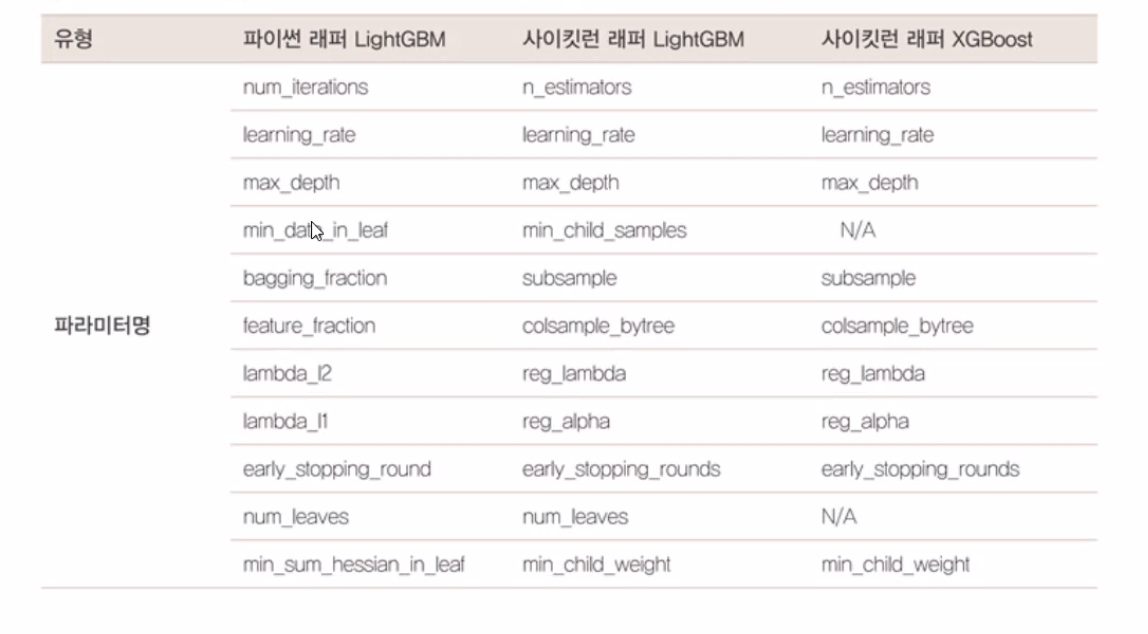

## LightGBM 적용한 위스콘신 유방암 예측

In [3]:
from lightgbm import LGBMClassifier

### (1) 데이터 로드 및 학습/테스트 데이터분할

In [4]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(ftr, target, test_size=0.2, random_state=156 )

### (2) LightGBM으로 학습

In [6]:
# 앞서 XGBoost와 동일하게 n_estimators는 400설정
lgbm_wrapper = LGBMClassifier(n_estimators= 400)

evals = [(X_test, y_test)]

# 학습 : 조기 중단 수행 가능(XGBoost와 동일함)
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100,
                eval_metric='logloss', eval_set=evals, verbose=True)

# 예측
preds = lgbm_wrapper.predict(X_test)
pred_proba= lgbm_wrapper.predict_proba(X_test)[:,1]

[1]	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_loglo

### (3) LightGBM 기반 예측 성능 평가

In [7]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

# 수정된 get_clf_eval() 함수 
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
 F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


In [8]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[33  4]
 [ 1 76]]
정확도: 0.9561, 정밀도: 0.9500, 재현율: 0.9870, F1: 0.9682, AUC:0.9905


### (4) plot_importance()를 이용하여 feature 중요도 시각화

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

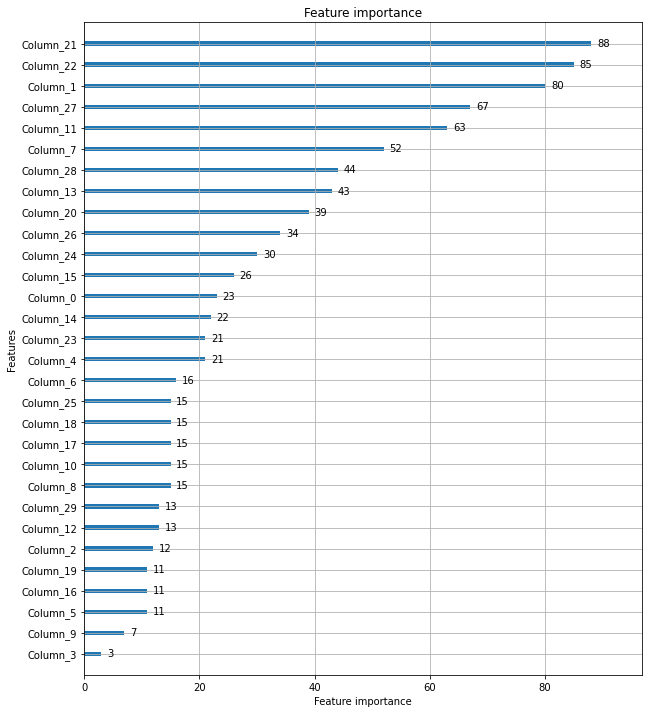

In [11]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12)) # 축반환
plot_importance(lgbm_wrapper,ax=ax) #학습이 된 xgb_model과 축

# F-score